In [1]:
using Interact, Plots, DifferentialEquations, LinearAlgebra, BifurcationKit, Setfield
using NonLinearDynamicsCourse

WebIO._IJuliaInit()

┌ Info: Precompiling NonLinearDynamicsCourse [6762868a-e78a-451a-a6ea-484381d56062]
└ @ Base loading.jl:1342


# Flujos 2D, Linealizacion, Estabilidad

Los puntos fijos de un sistema dinámico no-lineal 2D pueden ser de forma general de tipo silla, nodo/foco atractor/repulsor o centros, al igual que los sistemas lineales. Esto es porque MUY cerca (arbitrariamente cerca para ser mas precisos) del punto fijo el campo vector se puede aproximar como un sistema lineal. 

Recordemos que para flujos 1D $\dot{x}=f(x)$ el sistema linealizado era simplemente $\dot{x}=f'(x_*)(x-x_*)$, es decir que el coeficiente era la derivada del campo vector $f(x)$ evaluada en el punto fijo $x_*$. Habiamos mostrado esto con el desarrollo de Taylor de la función en un entorno del punto fijo.

Para flujos 2D el sistema linealizado va a estar dado por una matriz que se obtiene del desarrollo de Taylo de una función vectorial de dos variables. Nos vamos a ahorrar escribir ese desarrollo y vamos a indicar que el equivalente de la derivada ordinaria $f'(x)$ para una funcion vectorial (el campo vector) de dos variables es una matriz compuesta por las derivadas parciales del campo vector $[f(x,y),g(x,y)]$ de la siguiente forma:

${\bf J}(x,y) =
\begin{pmatrix}
\displaystyle\frac{\partial f}{\partial x} & \displaystyle\frac{\partial f}{\partial y}\\
\displaystyle\frac{\partial g}{\partial x} & \displaystyle\frac{\partial g}{\partial y}
\end{pmatrix}$

esta matriz $J$ es tambien conocida como el **Jacobiano** del campo vector $[f,g]$, y en principio es una función de $(x,y)$ como el campo vector. De hecho podriamos decir que es la **derivada del campo vector en dos dimensiones**

El sistema linealizado va a estar dado por la matriz Jacobiana evaluada en el punto fijo:

$\dot{\bf{u}} = \bf{J}(\bf{u_*})(\bf{u}-\bf{u_*})$

Para evaluar la estabilidad del punto fijo tenemos que calcular los autovalores de $bf{J}(\bf{u_*})$ y utilizar los mismos criterios que para los sistemas lineales.

En sintesis, el método de análisis de los flujos no lineales 2D consta de los siguientes pasos:

1. Calcular y/o graficar las nuclinas $f(x,y)=0$ $g(x,y)=0$
2. Determinar los puntos fijos $(x_*,y_*)$ a partir del cruce de las nulclinas
3. Calcular la matriz Jacobiana ${\bf J}(x,y)$ a partir de las derivadas parciales del campo vector
4. Evaluar la matriz Jacobiana en cada uno de los puntos fijos ${\bf J}(x_*,y_*)$
5. Para cada uno de los puntos fijos calcular la traza y el determinante de ${\bf J}(x_*,y_*)$ para determinar a que clase pertenece (nodo/foco repulsor/atractor o punto silla, o eventualmente centro)
6. Para los puntos silla determinar las direcciones de los autovectores y evolucionar condiciones inciales en esa direccion en un entorno del punto fijo hacia adelante en el tiempo para las direcciones inestables y hacia atrás en el tiempo para las estables.

El último paso es la generalización del análisis que hacíamos de las autodirecciones estables como "divisorias de aguas" para los sistemas lineales y corresponde al calculo de las **variedades estable e inestable** del punto silla que vamos a ilustrar primero con un ejemplo concreto.

# Análisis de sistema minimal con nolinealidad cuadrática


Vamos a empezar con un sistema con la nolinealidad más simple posible (un solo término cuadrático) dependiente de un parámetro $a>0$:

$f(x,y) = a-y$

$g(x,y) = x^2-y$

Las primera nulclina es el eje horizontal $y=a$ y la segunda es una parábola que pasa por el origen $y=x^2$.
Estas nulclinas se cortan en dos puntos $x=\pm\sqrt{a}$. 

Veamos primero las nulclinas y el campo vector:

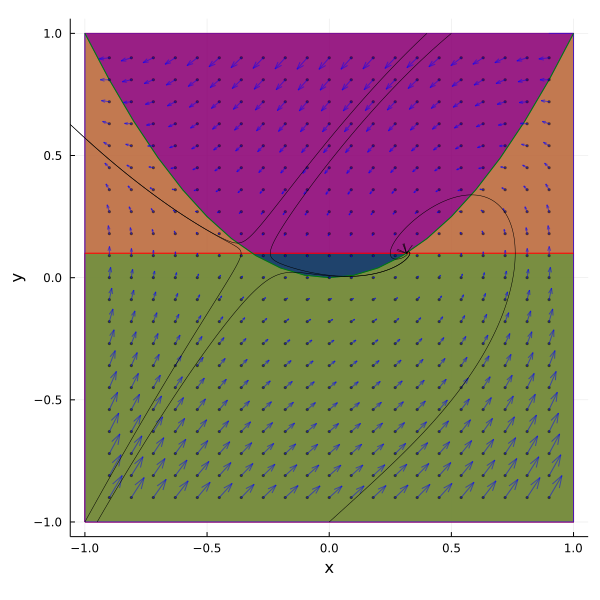

In [2]:
function cuad!(du,u,p,t)
    du[1]=p[1]-u[2]
    du[2]=u[1]*u[1]-u[2]
    du
end
u0_arr=[[-1.0;-1.0],[-0.95;-1.0],[0.4;1.0],[0.5;1.0],[0.0;-1.0]]
flux2d_nullclines(cuad!,u0_arr,30.0,[0.1];vectorfield=true,size=(600,600))

Además del campo vector y las nulclinas evolucionamos varias condiciones iniciales. Evolucionar distintas condiciones iniciales nos sirve también para hacer un primer estudio exploratorio y entender cómo está organizado el flujo global. 

En toda la región inferior $y<0$ excluyendo la parábola el flujo va hacia arriba y la derecha. 

La parte de flujo que pasa por la derecha de la parábola se mete en la zona naranja que tuerce el flujo hacia la izquierda y lo hace entra en la magenta, que lo tuerce para abajo, es decir que de forma global esta porcion de flujo se enrolla en sentido antihorario. De esa parte de flujo "enrollado" hay a su vez una porcion que pasa a la zona cyan que vuelve a torcer el flujo a la izquierda y termina de dar un giro completo en torno al punto fijo de la derecha (ver por ejemplo la trayectoria que arranca en $x=0$,$y=-1$). Esto ya hace presuponer que ese punto fijo es un atractor. 

En cambio la parte de flujo que pasa por la izquierda de la parabola pasa por la zona naranja de la izquierda, se tuerce a la izquierda y se aleja definitivamente. 

Finalmente hay un flujo que viene "de arriba" por la región magenta que también se divide. La porción izquierda entra en la zona naranja de la izquierda y se une al flujo que se aleja en esa dirección, mientras que otra parte entra en la región cyan y se enrolla en torno al atractor

Todo esto último hace presuponer que el punto fijo de la izquierda es un saddle (punto silla). Hay cuatro condiciones iniciales que elegimos justamente de un lado y del otro la separatiz del flujo


## Linealización

Vamos a pasar ahora a la parte analítica. Calculamos la matriz Jacobiana del sistema. Para ello tenemos que calcular cada una de las derivadas parciales:

$\frac{\partial f}{\partial x}=0 \quad$  ya que $f$ no depende de x

$\frac{\partial f}{\partial y}=-1 \quad$  ya que la derivada de una funcion lineal es la pendiente

$\frac{\partial g}{\partial x}=2x \quad$  la derivada de la funcion cuadratica $x^2$ es $2x$

$\frac{\partial g}{\partial y}=-1 \quad$  ya que la derivada de una funcion lineal es la pendiente

La matriz Jacobiana es entonces.

$\begin{pmatrix}
0 & -1\\
2x & -1
\end{pmatrix}$

esa matriz evaluada en los puntos fijos me dice como se comporta el flujo en un entorno local de los mismos. Esto es el sistema **linealizado** en un entorno de los mismos. 

Por ejemplo, en este caso para los puntos fijos la matriz va a ser:

$\begin{pmatrix}
0 & -1\\
-2\sqrt{a} & -1
\end{pmatrix}$

para el punto fijo de la izquierda (x<0) y tiene determinante negativo asi que es un punto silla para todos los valores de $a>0$.

Y para el punto fijo de la derecha la matriz sera:

$\begin{pmatrix}
0 & -1\\
2\sqrt{a} & -1
\end{pmatrix}$

que tiene determinante positivo y traza negativa asi que es un atractor (dependiendo del valor de $a$ puede ser un foco o un nodo. Algo que es consistente con lo se veia en el retrato de vases y el campo vector.


# Variedades Estable e Inestable

Otra representacion que es muy util para inferir el flujo en todo el espacio de fases es la de las **variedades estable e inestable** de los puntos fijos (cuando son puntos sillas sobre todo). Las variedades en los flujos 2D son curvas tangentes a las direcciones determinadas por los autovectores del jacobiano (en el caso en el que sean reales). 
Y quedan definidas por ser invariantes frente al flujo.

En el caso de los sistemas lineales habiamos visto que para autovalores reales existian rectas dadas por la dirección de los autovalores que eran invariantes frente al flujo, es decir que cualquier punto sobre estas rectas evolucionaba en el tiempo sobre la misma recta sin apartarse de ella. Las variedades son la generalización de esto. Son curvas en el espacio de fase que convergen/divergen al punto fijo y son invariantes frente al flujo. Cerca del punto fijo van a ser tangentes a la dirección dada por uno de los autovectores del Jacobiano. Por lo tanto la forma numérica de calcular las variedades es colocar una condición inicial muy próxima al punto fijo en la dirección del autovector y evolucionar haca adelante en el tiempo si es una direccion inestable y hacia atrás en el tiempo si es estable.


En particular las variedades estables de los puntos silla son relevantes porque actuan como separatrices del flujo. Para ilustralo mejor vamos a verlo en el caso del flujo nodo-silla anterior. Solo vamos a calcular las variedades del punto fijo de la izquierda que es un punto silla. Vamos a usar otra funcion de la libreria del curso  `plot_manifolds`, que necesita que le pasemos de forma explicita el jacobiano como una funcion in-place:

In [3]:
function cuad_jac(u,p) 
  J = Array{Float64, 2}(undef, 2, 2)
  J[1,1] = 0
  J[1,2] = -1.0
  J[2,1] = 2*u[1]
  J[2,2] = -1.0
  return J
end

cuad_jac (generic function with 1 method)

La función `flux2D_manifolds` recibe como argumentos obligatorios:
- la funcion que calcula el campo vector 
- la funcion que calcula el jacobiano
- un array con los puntos fijos
- el vector de parametros

Como parámetros opcionales recibe:
- el tiempo de integracion tmax
- el apartamiento del punto fijo en la direccion del autovector delta
- xlims, ylims los limites del grafico

In [ ]:
@manipulate throttle=0.1 for a=0:0.001:0.5
    fp_array=[[-sqrt(a);a],[sqrt(a);a]]
    flux2d_manifolds(cuad!,cuad_jac,fp_array,[a];
        tmax=300,delta=1e-7,xlims=[-2,2],ylims=[-2,2])
end    

Las dos ramas de la variedad estable del punto silla (en azul) funcionan como separatrices del flujo en dos regiones: a la izquierda y arriba del punto fijo donde todas las condiciones iniciales divergen a infinito, y hacia la derecha y abajo donde todas las condiciones iniciales convergen al atractor. Esta ultima región se conoce como la **cuenca de atracción** del atractor. Notar como a medida que disminuye $a$ la rama superior de la variedad estable se va curvando y rodeando al atractor y reduciendo su cuenca de atracción hasta que desaparece cuando $a=0$ y colapsan los dos puntos fijos (y tenemos una bifurcacion de nodo-silla)

Vamos a realizar ahora un análisis de algunos flujos 2D clásicos y relativamente sencillos.

# Modelo de Predador-Presa Lotka Volterra

Los modelos de dinamica de poblaciones en 1D se pueden escribir de forma general como 

$\dot{x} = R(x) x$

donde $R(x)$ es la tasa de reproduccion y extincion de la especie. Por ejemplo $R(x)=R(1-x/K)$ para la ecuacion logistica o $R=R(1-x/K)-\frac{x}{1+x^2}$ para la logistica con outbreak. Si ahora tenemos dos especies y una preda a la otra podemos esperar de forma general que la tasa de reproduccion y extincion dependa de ambas poblaciones, es decir:

$\dot{x} = R(x,y) x$

$\dot{y} = S(x,y) y$

De forma independiente Vito Volterra (1926) y Alfred Lotka (en realidad estudiando un modelo para las reacciones autocataliticas), propusieron la siguiente forma sencilla para la tasa de crecimiento de la presa $R(x-y)=b-cy$ donde $b$ es la tasa de crecimiento de la especie y $c$ es el impacto de la predación. Notar que el crecimiento no depende de los predadores pero su extincion si. Mientras que para la poblacion de predadores sucede a la inversa, su crecimiento depende de la existencia de presa (podemos pensar que aumenta la capacidad del sistema) mientras que su extincion no (es fija por muerte natural). En ese caso $S(x,y)=ax-d$.

Las ecuaciones de Lotka Volterra son entonces

$\dot{x} = (b-cy)x$

$\dot{y} = (ax-d)y$

Notar que hay terminos lineales: $bx$ crecimiento de la poblacion de presa, $-dy$ extincion de la poblacion de predadores que no dependen de la interaccion. Y por otro lado hay dos terminos que dependen de la interaccion, es decir del producto entre las dos poblaciones: $-cxy$ el impacto de la predacion en la poblacion de presa, y $axy$ el impacto de la poblacion de presa (recursos disponibles) en la capacidad de la poblacion de predadores.

In [16]:
function volterra!(du,u,p,t)
    (a,b,c,d) = p
    du[1] = (b-c*u[2])*u[1]
    du[2] = (a*u[1]-d)*u[2]
    du
end    

volterra! (generic function with 1 method)

Vamos a comenzar calculando las nulclinas analítica y numéricamente. Notar que cada una de las componentes del campo vector tiene la forma de un producto que se va a hacer cero cuando alguno de los dos sea cero. La primer nulclina queda definida entonces para todos los puntos del plano que cumplan: $x=0$ o bien $y=b/c$ que forman dos rectas perpendiculares orientadas como los ejes de coordenadas que se cortan en el punto $(0,b/c)$. Ese punto no es un punto fijo porque solo satisface la primera ecuacion. Esta "curva" nullclina es una cruz. Lo mismo sucede con la segunda nulclina que esta formada por dos rectas en cruz que se cortan en el punto $(d/a,0)$. Si colocamos ambas cruces en el plano se van a cortar en dos puntos que esos si corresponden a los puntos fijos: $\bf{u^*_1}=(0,0)$ y $\bf{u^*_2}=(d/a,b/c)$. Veamos que nos da el calculo numérico para un caso particular de los parámetros.

In [ ]:
flux2d_nullclines(volterra!,[0.5,0.5,0.5,0.5];xlims=[-0.1,1.5],ylims=[-0.1,1.5],vectorfield=true,size=(600,600))

Recordar que los parámetros tienen que ser positivos pero ademas hay dos parametros ($a$ y $c$) que no pueden ser cero porque harian "explotar" el sistema (el punto fijo $\bf{u^*_2}$ se mueve a infinito y me queda un sistema lineal). 

Por otra parte sólo tiene sentido en el modelo la región $x>0$ $y>0$. Graficamos una porcion de negativos para poder ver las nulclinas. Los "autocruces" de las nulclinas se ven raros en el metodo numérico porque utiliza una funcion de curvas de nivel para detectar los ceros. Pero lo importante es que tenemos nuestros puntos fijos en los cortes "rojo-verde" que ya habíamos anticipado. 

El ordenamiento de los colores de las regiones de la region superior izquierda es el mismo del oscilador armónico lo cual ya nos debería hacer sospechar que el flujo va a rotar en torno a ese punto fijo (se ve en el campo vector también). Mientras que el ordenamiento de los colores de las regiones en la esquina en torno al $(0,0)$ es el de un punto silla. Esos dos elementos podrían servime para imaginar como está organizado el flujo pero vamos a continuar con el análisis de estabilidad.

Vamos a calcular primero el Jacobiano de forma general derivando el campo vector. 

$\frac{\partial f}{\partial x}=b-cy \quad$  ya que es el factor que multiplica a $x$ en la primera ecuación.

$\frac{\partial f}{\partial y}=-cx \quad$  ya que es la derivada del unico término que depende de $y$

$\frac{\partial g}{\partial x}=ay \quad$  ya que es la derivada del unico término que depende de $x$

$\frac{\partial g}{\partial y}=ax-d \quad$  ya que es el factor que multiplica a $y$ en la segunda ecuación

La matriz Jacobiana es entonces:

$\begin{pmatrix}
b-cy & -cx\\
ay & ax-d
\end{pmatrix}$

Evaluada en el primer punto fijo $\bf{u^*_1}=(0,0)$ es:

$\begin{pmatrix}
b & 0\\
0 & -d
\end{pmatrix}$

que es una matriz diagonal con un autovalor positivo asociado a un autovector en la direccion $x$ (ver el campo vector arriba) y un autovalor negativo asociado a un autovector en la dirección $y$ es decir que en la región que nos interesa el flujo se mueve bajando por el eje $y$ hacia el punto fijo en el origen y luego alejándose por el eje $x$ para los positivos.

Veamos que interpretación tiene este punto fijo y su entorno en el modelo de predador presa (más allá que $(0,0)$ sea un punto fijo tiene sentido lógico en términos del modelo). El primer movimiento descendente paralelo al eje $y$ corresponde a una situación con muy poca población de presa que lleva a que el término dominante sea la extinción de los predadores $-dy$. Pero cuando los predadores son también muy pocos la población de presa se empieza a recuperar. El movimiento creciente paralelo al eje $x$ corresponde a una población de presa que crece exponencialmente aprovechando que hay muy pocos predadores y el término que domina es $ax$. Es decir que la asimetría de los ejes $x$ e $y$ en el punto silla se refleja en el modelo en la diferencia en la forma en que ambas poblaciónes reaccionan a la escasez de la otra población: los predadores la padecen y las presas la aprovechan.

Pasamos ahora a la evaluación en el segundo punto fijo $\bf{u^*_2}=(d/a,b/c)$. El Jacobiano queda:

$\begin{pmatrix}
0 & -cd/a\\
ab/c & 0
\end{pmatrix}$

El determinante ($\Delta=bd$) es siempre positivo porque los parámetros son positivos. Y la traza es cero. Tenemos el caso particular de un centro.

Acá podría venir una sorpresa porque habíamos dicho que la linealización nos sirve para determinar la estabilidad de todos los puntos fijos en sistemas no lineales estructuralmente estables y este caso no lo es. Que la linealización me de un centro no implica que en el sistema no lineal el flujo en un entorno del punto fijo sea topológicamente equivalente. Dicho de otro modo, este punto fijo podría ser un atractor o un repulsor dependiendo de los términos no lineales. En este caso particular el flujo si forma trayectorias cerradas en torno a este punto fijo (algo que se puede probar pero que excede este curso).

Cual es la interpretación de este punto fijo y de la oscilación en torno a él en términos del modelo?
Este es un punto de equilibrio en el que ambas poblaciones alcanzaron su capacidad. Pero si por ejemplo la población de presa es al inicio un poco mayor que este punto de equilibrio la capacidad de la población de predadores aumenta y así lo hace su población (zona naranja del gráfico de nulclinas) al mismo tiempo que la población de presa comienza disminuir y baja la capacidad de la población de predadores y su población (zona magenta). Cuando la población de predadores merma la población de presa comienza a recuperarse (zonas cyan y azul) y el ciclo se repite. 

A su ves este sentido de giro es compatible, a medida que las órbitas se aproximan a los ejes con el sentido de flujo del punto silla del origen. Todas las soluciones son orbitas cerradas entorno a  $\bf{u^*_2}$ que se van deformando a medida que se acercan a los ejes $x$ e $y$. De esta forma el modelo de Lotka Volterra lleva a la oscilacion de las poblaciones, algo que se observa en muchos sistemas simples.


In [ ]:
@manipulate throttle=.05 for u1=0:0.1:1,u2=0.1:0.1:1,a=0.1:0.1:1,b=0:0.1:1,c=0.1:0.1:1,d=0:0.1:1
    sol = solve(ODEProblem(volterra!, [u1; u2], (0, 100), [a,b,c,d]));
    p1 = plot(sol)
    p2 = plot(sol,vars=(1,2),arrow=true)
    plot(p1,p2,layout=(1,2),size = (900,450))
end

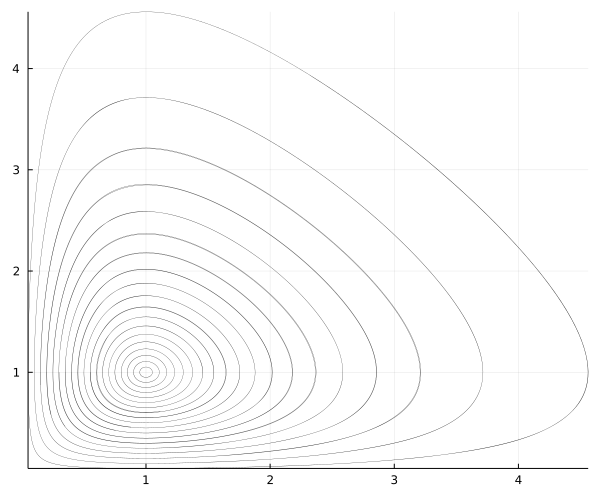

In [17]:
# Multiples trayectorias
u0_arr=0.05:0.05:1.0
a=0.5;b=0.5;c=0.5;d=0.5
function prob_func(prob,i,repeat)
  remake(prob,u0=[u0_arr[i];b/c])
end
prob = ODEProblem(volterra!,[0.1; b/c], (0, 30), [a,b,c,d]);
sol = solve(EnsembleProblem(prob,prob_func=prob_func),
    EnsembleThreads(),trajectories=length(u0_arr))
plot(sol,vars=(1,2),color=:black,linewidth=0.2,size = (600,500))

# Modelo simple de epidemia. SIR

EL modelo mas simple de propagacion de epidemia (propuesto en 1927 por Kermack & McKendrik) considera una poblacion  constante dividida en tres "compartimentos": los Suceptibles $S$ (individuos que pueden contagiarse), los Infectados $I$, y los Recuperados $R$ que no se vuelven a contagiar. Como la suma de los tres es constante en realidad se trata de un modelo 2D, pero lo usual es escribir las ecuaciones diferenciales para las tres poblaciones:

$\dot{S} = -\beta SI$

$\dot{I} = \beta SI - \gamma I$

$\dot{R} = \gamma I$

donde usamos la poblacion normalizada ($S+I+R=1$). Como $R$ no aparece en las dos primeras ecuaciones podemos resolver esas dos primeras y luego calcular $R=1-S-I$

$\dot{x} = -\beta xy$

$\dot{y} = \beta xy - \gamma y$




In [ ]:
function sir!(du,u,p,t)
    (β,γ) = p
    du[1] = -β*u[1]*u[2]
    du[2] = β*u[1]*u[2]-γ*u[2]
    du
end    

Al igual que en el caso anterior las nulclinas para $S$ e $I$ son "cruces" formadas por rectas paralelas a los ejes.
La primer nulclina de hecho son los propios ejes coordenados porque se anula cuando $x=0$ o $y=0$. Pero lo particular de este sistema es que la segunda nulclina también incluye al eje horzontal $y=0$ además de en el eje verical $x=\gamma/\beta$. Como consecuencia estas dos "curvas" se intersectan todo a lo largo del eje $y=0$ que comparten. Esto tiene sentido en términos del modelo porque $y=Infectados$ y si la cantidad de infectados es cero no hay evolución de ninguna de las variables. 

Este es un sistema bastante particular porque tiene "infinitos" puntos fijos sobre la recta $y=0$. Esto quiere decir que el estado final depende de los parametros y el valor inicial pero puede ser cualquier punto sobre esa recta (va a depender de la historia del sistema).

El estudio de la interpretación de las trayectorias y los parámetros queda como ejercicio.

In [ ]:
flux2d_nullclines(sir!,[0.9;0.1],30.0,[1.0,0.2];xlims=[-0.1,1.1],ylims=[-0.1,1.1],vectorfield=true,size=(600,600))

In [ ]:
@manipulate throttle=0.5 for i=0:0.01:1, β=0:0.01:1,γ=0:0.01:1,tmax=10:10:500
    sol = solve(ODEProblem(sir!, [1.0-i; i], (0, tmax), [β,γ]));
    p1 = plot(sol,vars=(0,1),label="Suceptibles")
    plot!(p1,sol,vars=(0,2),label="Infectados")
    plot!(p1,sol,vars=((t,x,y)->(t,1-x-y),0,1,2),label="Recuperados")
    p2 = plot(sol,vars=(1,2),arrow=true)
    plot(p1,p2,layout=(1,2),size = (900,450))
end   

# Oscilador de Duffing

Vamos a pasar a ver un sistema con un repertorio un poco más variado de comportamientos y que más adelante (al agregar un término forzado) va a ser nuestra guía para entrar a los sistemas caóticos asi que lo vamos a estudiar con bastante detalle.

Este sistema se obtiene al agregar términos cuadráticos o cúbicos a la fuerza restitutiva de un oscilador, por ejemplo en su versión más conocida  $\beta x - x^3$ en lugar de $-Kx$. En 1918 George Duffing publico un trabajo estudiando sistemáticamente la influencia de los diferentes términos no lineales en el oscilador, por lo que a este sistema se lo conoce como oscilador de Duffing.

Asi como el Oscilador armónico (sistema lineal) se puede ver como el movimiento unidimensional de una particula en un pozo. El oscilador de Duffing corresponde al movimiento en un doble pozo (que de todas formas mediante un cambio de parametro se puede volver de pozo simple pero sin dejar de ser no lineal). 

<div>
<img src="../files/single_double_well.png" width="500px">
</div>
 
Un sistema fisico (si bien algo artificial) que tiene este comportamiento se puede armar con una lengueta metalica flexible puesta entre dos imanes:
<div>
<img src="../files/duffing.png" width="300px">
</div>

Si la potencia de los imanes no supera la rigidez de la lengueta tenemos la situacion de un unico pozo (si bien no es una oscilacion libre por la presencia de los imanes) y hay un solo atractor (el centro). Si la rigidez baja (o los imanes se acercan, o se ponen imanes mas potentes) hay dos situaciones de equilibrio estable (apuntando a uno u otro iman) separados por un punto inestable (que como vamos a ver mas adelante es un punto silla).

Las ecuaciones del oscilador de Duffing son las siguientes:

$\dot{x} = y$

$\dot{y} = -\gamma y + \beta x -  x^3$

En el caso de la lengueta con los imanes $x$ es la posicion horizontal de la punta, $y$ la velocidad (de ahi la primera ecuacion diferencial), $\gamma$ es la disipacion del aire y la friccion (igual que en el caso del resorte es una fuerza que se opone a la velocidad) y en $\beta$ esta resumida la relacion entre la fuerza de los imanes y la rigidez de la lengueta. Si $\beta$ es positivo ganan los imanes y si es negativo gana la rigidez. Notar que el termino cubico es el que termina ganando siempre, muy lejos del equilibro la fuerza es siempre atractiva, por lo tanto el sistema no va a explotar.

Este sistemita simple al ser forzado periodicamente presenta CAOS!

## Puntos fijos Oscilador de Duffing
Vamos a calcular los puntos fijos primero por el metodo de las nulclinas.

La primera nuclina es trivial, me da una recta horizontal $y=0$ con lo cual todos los puntos fijos van a estar sobre el eje $x$

La segunda nulclina se resuelve en una ecuacion cubica para $y$ en funcion de $x$:

$y = (\beta x - x^3)/ \gamma$

y recordemos que una cubica podia tener forma de "N" si el termino lineal y cubico tenian signo diferente ($\beta > 0$) o una doble curva suave si tenian el mismo signo ($\beta < 0$). $\gamma$ actua solo como factor de escala haciendo mas alta o mas baja la "N". 

<div>
<img src="../files/cubic.png" width="500px">
</div>

En este caso si bien usamos el metodo de las nulclinas como de la primera ecuacion sabemos que $y=0$ los puntos fijos van a ser las raices de esta cubica, es decir donde corte el eje horizontal. Por lo tanto basta con resolver 

$\beta x = x^3$

que tiene una solucion trivial $x^*_1=0$ y despues, solo para el caso de $\beta>0$ dos soluciones simetricas (que se obtienen dividiendo ambos miembros de la ecuacion anterior por $x$ ya que es diferente de 0) en 

$x^*_{2,3} = \pm \sqrt{\beta}$

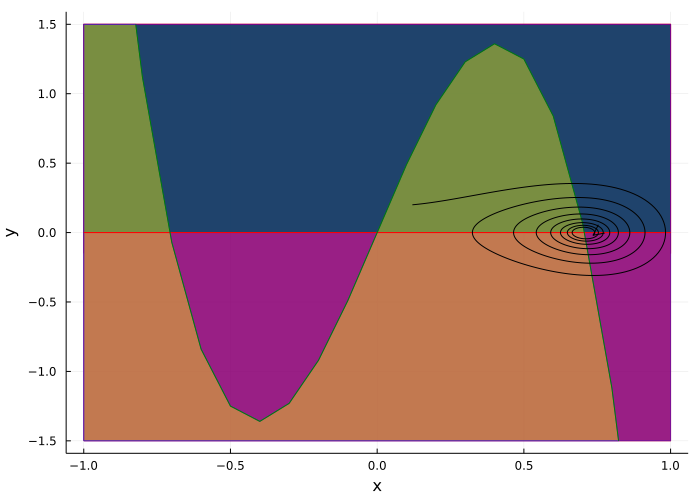

In [4]:
#definimos la Ed para el oscilador de Duffing
function duffing!(du,u,p,t)
    (γ,β)=p
    du[1] = u[2]
    du[2] = -γ*u[2]+u[1]*(β-u[1]*u[1])
    du
end    

flux2d_nullclines(duffing!,[0.12;0.2],50.0,[0.1,0.5];ylims=[-1.5,1.5])

Notar que en este caso tenemos tres puntos fijos, por el ordenamiento de las regiones podemos saber que es un atractor, un punto silla y un foco. 

In [8]:
@manipulate throttle=0.5 for x0=-1:0.1:1, y0=-1:0.1:1,β=-1.0:0.1:1.0,γ=0:0.01:1.0
    flux2d_nullclines(duffing!,[x0;y0],50.0,[γ,β];ylims=[-1.5,1.5])
end    

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["x0"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 21, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
11, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Camilo\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Camilo\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Camilo\\.julia\\packages\\InteractBase\\h8Fwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Camilo\\.julia\\packages\\InteractBase\\h8Fwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Camilo\\.julia\\packages\\Interact\\pVyN2\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000000f248e20, Task (runnable) @0x000000000f248e20), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-1.0\",\"-0.9\",\"-0.8\",\"-0.7\",\"-0.6\",\"-0.5\",\"-0.4\",\"-0.3\",\"-0.2\",\"-0.1\",\"0.0\",\"0.1\",\"0.2\",\"0.3\",\"0.4\",\"0.5\",\"0.6\",\"0.7\",\"0.8\",\"0.9\",\"1.0\"],\"changes\":WebIO.getval({\"name

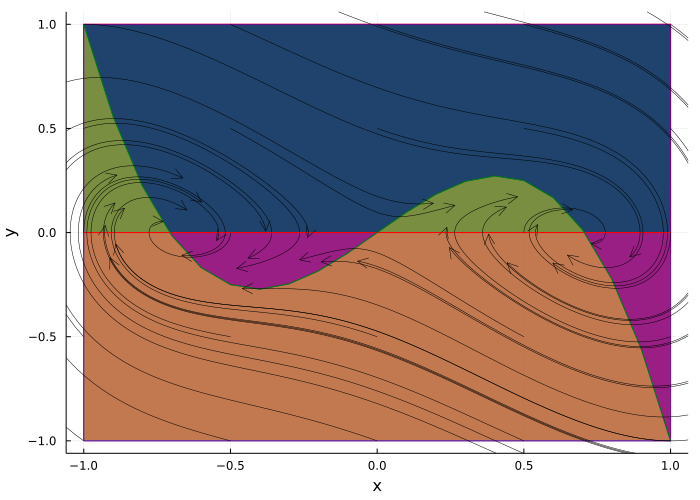

In [7]:
u0_arr = vec([[-1+i*0.5,-1+j*0.5] for i=0:5, j=0:5])
flux2d_nullclines(duffing!,u0_arr,5.0,[0.5,0.5])

# Estabilidad: Oscilador de Duffing

Vamos a estudiar ahora la estabilidad del Oscilador de Duffing:

$\dot{x} = y$

$\dot{y} = -\gamma y + \beta x -  x^3$

Que, como vimos, tiene un punto fijo siempre en $x^*_1=0$ y luego para $\beta>0$ un par de puntos fijos en $x^*_{2,3} = \pm \sqrt{\beta}$

El primer paso es calcular la matriz Jacobiana, lo hacemos paso por paso:

${\bf A} =
\begin{pmatrix}
\frac{\partial f}{\partial x} & \frac{\partial f}{\partial y}\\
\frac{\partial g}{\partial x} & \frac{\partial g}{\partial y}
\end{pmatrix}$

Calculamos cada una de las derivadas

$\frac{\partial f}{\partial x}=0 \quad$  ya que $f$ no depende de x

$\frac{\partial f}{\partial y}=1 \quad$  ya que la derivada de una funcion lineal es la pendiente

$\frac{\partial g}{\partial x}=\beta-3x^2 \quad$  la derivada de la funcion cubica es $\beta-3x^2$

$\frac{\partial g}{\partial y}=-\gamma \quad$  ya que la derivada de una funcion lineal es la pendiente

La matriz Jacobiana es entonces.

$\begin{pmatrix}
0 & 1\\
\beta-3x^2 & -\gamma
\end{pmatrix}$

$\gamma$ es siempre positivo (dispacion), por lo tanto la traza es siempre negativa (sera atractor o punto silla dependiendo del determinante). 

Ahora hay que evaluarla en los puntos fijos.
La evaluamos primero en el punto fijo 

$x=0$.

$\begin{pmatrix}
0 & 1\\
\beta & -\gamma
\end{pmatrix}$

el determinante es $-\beta$. Es simple, cuando tenemos un punto fijo $\beta<0$, el determinante es positivo el punto fijo es atractor (la traza es siempre negativa). Es tiene sentido porque es la situacion en la que la lengueta no llega a ser atraida por los imanes y se queda en equilibrio en el centro.
En cambio, cuando tenemos tres puntos fijos ($\beta>0$) este pasa a ser el del medio y el determinante es negativo por lo tanto es un punto silla. 

Veamos ahora el caso de los otros dos puntos fijos, notando que como en el Jacobiano aparece solo $x^2$, los dos puntos fijos tienen el mismo Jacobiano:

$x=\pm \sqrt{\beta}$.

$\begin{pmatrix}
0 & 1\\
-2\beta & -\gamma
\end{pmatrix}$

el determinante es $2\beta$, o sea tiene el signo inverso que el del determinate del Jacobiano del punto fijo del medio, lo cual una vez mas tiene sentido porque cuando hay tres puntos fijos vimos que ese punto se transforma en un punto silla y los puntos en $x=\pm \sqrt{\beta}$ solo existen para $\beta>0$, o sea tienen siempre determinate positivo (y traza negativa siempre) por lo tanto son atractores. Es decir que para el caso de tres puntos fijos tenemos un punto silla en el medio separando dos atractores.

El punto silla es inestable en la direccion del movimiento, porque si trato de poner la lengueta en el medio cuando los imanes atraen mucho no se queda en ese sitio y se va para uno de los dos atractores (que obviamente son los imanes). Pero no es atractor en términos de la velocidad, ya que si una trayectoria pasa por el centro inestable va a perder velocidad por la friccion y el sistema va a ir decayendo. En el caso de mucho friccion ($\gamma$ muy alto) el sistema va pareciendose cada vez mas a un sistema 1D (verlo en el grafico interactivo)

In [9]:
function duffing_jac(u,p)
  J = Array{Float64, 2}(undef, 2, 2)
  J[1,1] = 0
  J[1,2] = 1.0
  J[2,1] = p[2]-2.0*u[1]*u[1]
  J[2,2] = -p[1]
  return J
end

duffing_jac (generic function with 1 method)

In [10]:
@manipulate throttle=0.1 for β=0:0.001:0.5,γ=0:0.001:0.5,tmax=10:10:300
    u0_array= [[-sqrt(β);0],[0;0],[sqrt(β);0]]
    flux2d_manifolds(duffing!,duffing_jac,u0_array,[γ,β];
        tmax=tmax,delta=1e-6,xlims=[-2,2],ylims=[-2,2])
end    

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["β"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 501, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
251, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Camilo\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Camilo\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Camilo\\.julia\\packages\\InteractBase\\h8Fwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Camilo\\.julia\\packages\\InteractBase\\h8Fwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Camilo\\.julia\\packages\\Interact\\pVyN2\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000000764c3d00, Task (runnable) @0x00000000764c3d00), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.001\",\"0.002\",\"0.003\",\"0.004\",\"0.005\",\"0.006\",\"0.007\",\"0.008\",\"0.009\",\"0.01\",\"0.011\",\"0.012\",\"0.013\",\"0.014\",\"0.015\",\"0.016\",\"0.017\",\"0.018\",\"0.019\",\"0.02\",\"0.

Notar como se modifica el enrollamiento de las variedades con el parámetro $\gamma$. Las inestables se espiralan en torno a cada uno de los atractores y las estables se espiralan hacia afuera rodeando los tres puntos fijos. Para valores más altos de $\gamma$ puede verse que las ramas azules de la variedad estable del saddle funcionan como separatrices del flujo que va a terminar en uno u otro  punto fijo. Todas las condiciones iniciales que terminar en un atractor forman la **cuenca de atracción** del mismo. Las variedades estables están formando entonces la frontera entre ambas cuencas de atracción (attractor basin).

Tenemos una función en el paquete del curso que permite graficar las cuencas de atracción de una lista de puntos fijos atractores: `attractor_basin` recibe como argumentos obligatorios
- la función del campo vector
- el vector de parámetros
- un array con lo puntos fijos atractores
- la distancia maxima al atractor (aumentar si no detecta la convergencia, de otra forma se puede subir el tmax, pero en realidad esta distancia tiene que ser la necesaria para discriminar entre diferentes atractores así que no es necesario que sea muy pequeña).

y los argumentos optativos son:
- delta (default 0.1) la resolucion espacial del grafico
- tmax, (default 1000.0) el tiempo máximo de integración
- xlims,ylims el rango del gráfico en $x$ e $y$

solved
plotting...


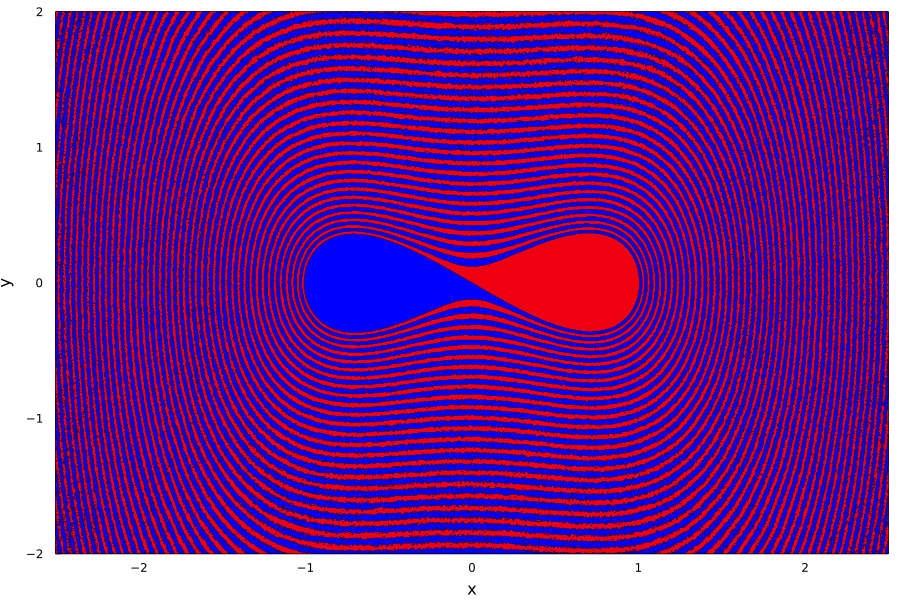

In [11]:
attractors=[[1.0,0.0],[-1.0,0.0]]
γ=0.015;β=0.5
p1 = attractor_basin(duffing!,[γ,β],attractors,1.5;delta=0.005,xlims=(-2.5,2.5),ylims=(-2.0,2.0))

## Oscilador de Duffing. Retrato de Fases Completo

La última función que vamos a usar del paquete es `phase_portrait` que realiza un retrato de fases completo: calcula los puntos fijos, grafica las nulclinas y las variedades estable e inestable. Recibe como argumentos obligatorios:
- la función del campo vector
- el vector de parámetros

y como optativos:
- tmax el tiempo maximo de evolucion de las variedades
- delta el desplazamiento en la direccion de los autovectores para el cáluclo de las variedades
- xlims, ylims el rango del gráfico

In [15]:
@manipulate throttle=0.1 for β=-0.5:0.001:0.5,γ=0:0.001:0.5
    phase_portrait(duffing!,[γ,β];delta=0.0001,xlims=[-2,2],ylims=[-2,2])
end    

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["β"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 1001, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
501, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Camilo\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Camilo\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Camilo\\.julia\\packages\\InteractBase\\h8Fwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Camilo\\.julia\\packages\\InteractBase\\h8Fwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Camilo\\.julia\\packages\\Interact\\pVyN2\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000002de9a0c90, Task (runnable) @0x00000002de9a0c90), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-0.5\",\"-0.499\",\"-0.498\",\"-0.497\",\"-0.496\",\"-0.495\",\"-0.494\",\"-0.493\",\"-0.492\",\"-0.491\",\"-0.49\",\"-0.489\",\"-0.488\",\"-0.487\",\"-0.486\",\"-0.485\",\"-0.484\",\"-0.483\",\"-0.482\",\"-